# Generalizing across actions !

In a euclidian latent space, assuming some relationships between actions, we may generalize their learned effects !

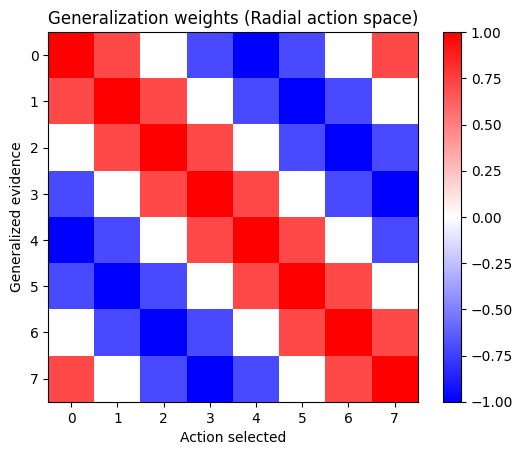

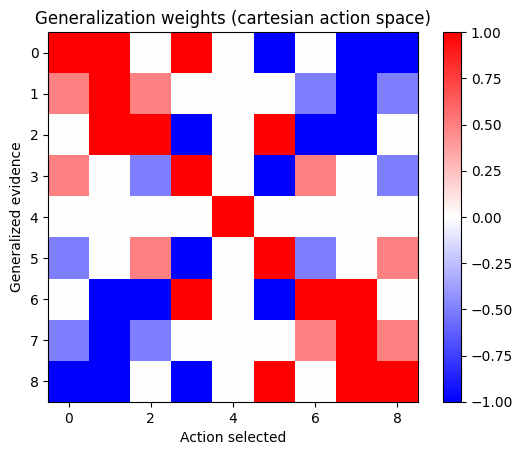

In [14]:
import numpy as np
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import vmap
from functools import partial

from generalize_helper import get_generalizing_table,generalize_across_actions,generalize_across_states,generalize_transition


# Radial plot : 
U = np.arange(8)
plt.imshow(get_generalizing_table(U,"radial"),cmap="bwr")
plt.xlabel("Action selected")
plt.ylabel("Generalized evidence")
plt.title("Generalization weights (Radial action space)")
plt.colorbar()
plt.show()

# Cartesian plot : 
U = np.arange(9)
plt.imshow(get_generalizing_table(U,"cartesian"),cmap="bwr")
plt.title("Generalization weights (cartesian action space)")
plt.xlabel("Action selected")
plt.ylabel("Generalized evidence")
plt.colorbar()
plt.show()


C:\Users\annic\AppData\Local\Temp\ipykernel_7820\2225665504.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


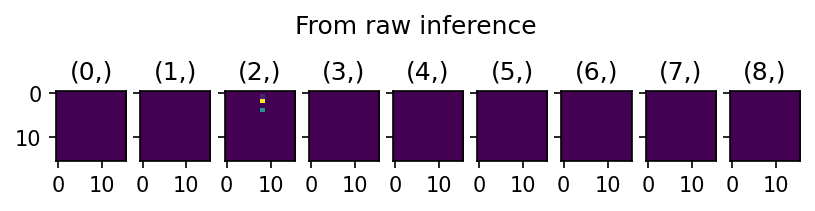

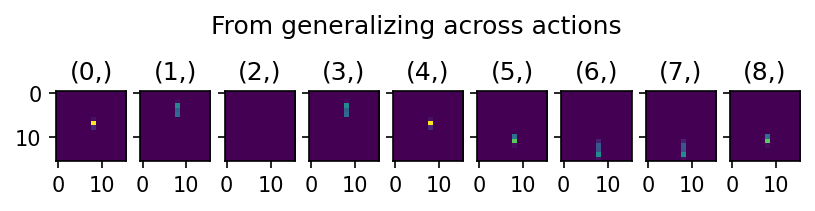

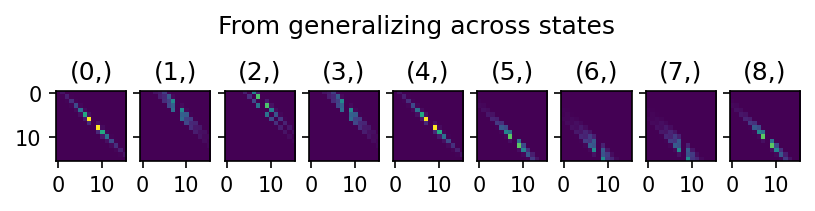

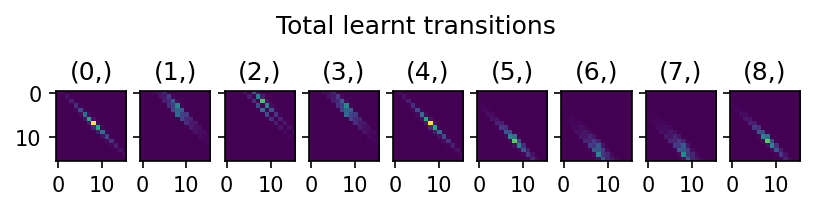

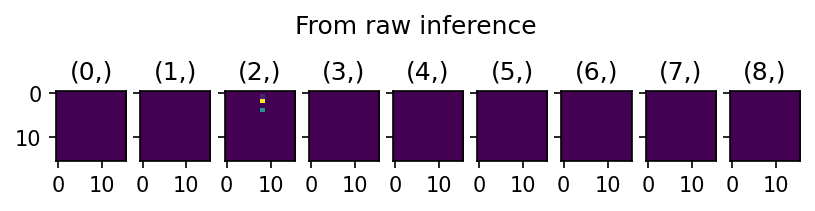

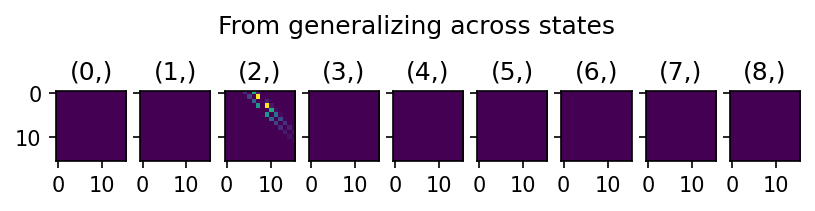

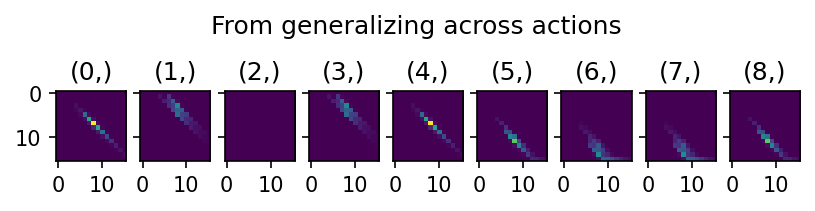

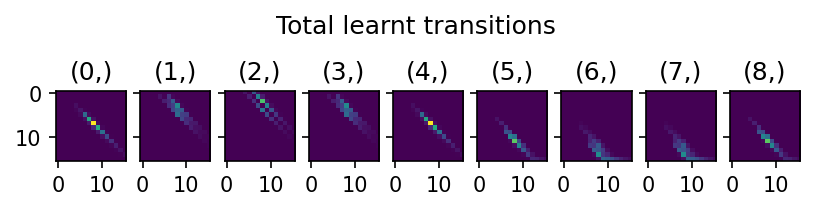

In [18]:
# Now, for the actual transition weights ! 

def plot_actions(b,title=""):
    Ns,_,Nu = b.shape
    fig,axs = plt.subplots(1,Nu,sharey=True,dpi=150)
    fig.suptitle(title,y=0.65)
    for act,ax in np.ndenumerate(axs):
        ax.imshow(b[...,act],vmin=0,vmax =jnp.max(b))
        ax.set_title("{}".format(act))
    fig.show()

action_space_structure = "radial"
Nu,Ns = 9,16
# raw_observed_action = jnp.array([0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0])
raw_observed_action = jax.nn.one_hot(2,Nu)

raw_observed_transition = np.zeros((Ns,Ns))
k = int(Ns/2.0)
raw_observed_transition[1,k] = 0.1
raw_observed_transition[2,k] = 0.95
raw_observed_transition[3,k] = 0.0
raw_observed_transition[4,k] = 0.5

db = jnp.einsum("ij,u->iju",raw_observed_transition,raw_observed_action)
action_generalization_factor = 0.99
action_generalization_table = get_generalizing_table(jnp.arange(Nu),action_space_structure)
fadeout_function = lambda x : jnp.exp(-0.5*x)


# Actions then states :
extrapolated_transitions_actions = generalize_across_actions(db,action_generalization_table,clip=False)
extrapolated_transitions_states = generalize_across_states(db+action_generalization_factor*extrapolated_transitions_actions,fadeout_function)
total_extrapolated_1 = extrapolated_transitions_states+action_generalization_factor*extrapolated_transitions_actions+db

plot_actions(db,"From raw inference")
plot_actions(extrapolated_transitions_actions,"From generalizing across actions")
plot_actions(extrapolated_transitions_states, "From generalizing across states")
plot_actions(total_extrapolated_1,"Total learnt transitions")




# States then actions:
extrapolated_transitions_states = generalize_across_states(db,fadeout_function)
extrapolated_transitions_actions = generalize_across_actions(db + extrapolated_transitions_states,action_generalization_table,clip=False)
total_extrapolated_2 = extrapolated_transitions_states+action_generalization_factor*extrapolated_transitions_actions+db

plot_actions(db,"From raw inference")
plot_actions(extrapolated_transitions_states, "From generalizing across states")
plot_actions(extrapolated_transitions_actions,"From generalizing across actions")
plot_actions(total_extrapolated_2,"Total learnt transitions")

Are there any difference between the two ?

C:\Users\annic\AppData\Local\Temp\ipykernel_7820\2225665504.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


-0.2208989
0.25721604


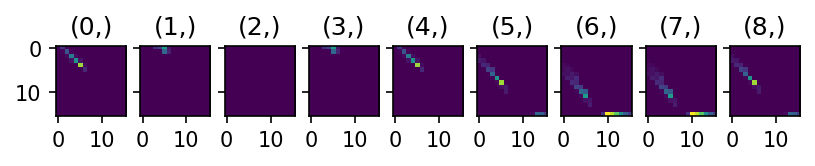

In [17]:
plot_actions(jnp.abs(total_extrapolated_2-total_extrapolated_1))
print(jnp.min(total_extrapolated_2-total_extrapolated_1))
print(jnp.max(total_extrapolated_2-total_extrapolated_1))

Differences between both compositions are due to clipping rules during state interpolation. Overall, it seems like a better idea to perform action interpolation before state interpolation (?). This is because the state interpolation occuring first means that part of this interpolation will get clipped. When the inter-action interpolation occurs, we fail to retrieve this clipped part... 

Note : There may be cases where the opposite occurs ?

 Maybe we could implement a method that does both state & action interpolation simultaneously. For now, this will suffice.